In [1]:
import pandas as pd 
import numpy as np

import shephard
from shephard.apis import uniprot, fasta
from shephard.interfaces import si_domains, si_tracks
from shephard.tools import domain_tools

In [2]:
### PLOTTING SETTINGS

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

AA_type_palette={'A':'#000000','I':'#000000','L':'#000000','M':'#000000','V':'#000000',
                 'F':'#f2a139','Y':'#f2a139','W':'#f2a139',
                 'D':'#eb3628','E':'#eb3628',
                 'R':'#201beb','K':'#201beb',
                 'P':'#bf42b2','C':'#fbe74f',
                 'N':'#306e22','Q':'#306e22','G':'#306e22','S':'#306e22','T':'#306e22','H':'#306e22'}

chem_type_palette={'fraction_aliphatic':'#808080',
                   'fraction_aromatic':'#f2a139',
                   'FCR':'#C03D3E',
                   'fraction_proline':'#bf42b2',
                   'fraction_cystine':'#fbe74f',
                   'fraction_polar':'#3A923A'}

aro_palette = sns.light_palette('#f2a139', reverse=False, as_cmap=True)
charge_palette = sns.light_palette('#C03D3E', reverse=False, as_cmap=True)
ali_palette = 'Greys'
chem_order = {'aliphatic':'#808080',
                   'aromatic':'#f2a139',
                   'charge':'#C03D3E',
                   'proline':'#bf42b2',
                   'cystine':'#fbe74f',
                   'polar':'#3A923A'}


def show_values(axs, orient="v", space=.01):
    """
    Addapted from:
    https://www.statology.org/seaborn-barplot-show-values/
    """
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

## Read in human data 

In [3]:
# read in human IDRs and a track with all the aromatic residues annotated

filename ='../shprd_data/human_proteome_validated.fasta'
human_prot = uniprot.uniprot_fasta_to_proteome(filename, invalid_sequence_action='convert')
si_domains.add_domains_from_file(human_prot, '../shprd_data/shprd_domains_human_IDRs_0.420.tsv')
si_domains.add_domains_from_file(human_prot, '../shprd_data/shprd_domains_human_plaac_PLDs.tsv')
si_domains.add_domains_from_file(human_prot, '../shprd_data/shprd_domains_human_QSGNTP_LCD.tsv')
si_tracks.add_tracks_from_file(human_prot,'../shprd_data/shprd_tracks_human_aromatic_resis.tsv', 'values')

### Idenify LCDs + analyize amino acid fractions and domain overlap

In [4]:
ov=0
for p in human_prot:
        
    # annotate add LCDs 
    for d in p.get_domains_by_type('QSGNTP_LCD'):

        # calculate sequence statistics for each LCD domain

        # get domain length 
        d_len = len(d.sequence)

        # demonstrate how to calculate sequence stats from track 
        d.add_attribute('fraction_aromatic', sum(d.get_track_values('aromatic_resi_track'))/ d_len)

        # demonstrate how to calculate stats from sequence 
        d.add_attribute('FCR', sum(map(d.sequence.count, ['D','E','R','K'])) / d_len)
        d.add_attribute('fraction_aliphatic', sum(map(d.sequence.count, ['A','L','V','I','M'])) / d_len)
        d.add_attribute('fraction_polar', sum(map(d.sequence.count, ['Q','S','G', 'N', 'T'])) / d_len)
        d.add_attribute('fraction_proline', sum(map(d.sequence.count, ['P'])) / d_len)

        # annotate polar_LCDs that overlap with IDRs (overlap is defined very loosely as overlap by 1 residue or more)
        for idr in p.get_domains_by_type('IDR'):
            # test for any overlap 
            if domain_tools.domain_overlap(d,idr): 
                d.add_attribute('IDR_overlap',True)
                ov+=1
                break
        

print("Number of IDR overlapping %s domains identified:" % 'QSGNTP_LCD' , ov)

Number of IDR overlapping QSGNTP_LCD domains identified: 3108


In [5]:
## Saving a selection as a proteome attribute for quick access ## 

# Here we create a shortcut for the list of overlapping LCDs, to do this 
# we save it as a proteome attribute that can be called later.

lcd_idr_overlap =[]

# itterate all domains
for d in human_prot.domains:
    # get domains by type 
    if d.domain_type == 'QSGNTP_LCD':
        # filter by domain attribute 
        if 'IDR_overlap' in d.attributes:
            lcd_idr_overlap.append(d)
            
        # here now later on we added a second analysis where we check 
        # to annotate for those that overlap with plaac_LCDs 
        for pld in d.protein.get_domains_by_type('plaac_pld'):
            if domain_tools.domain_overlap(d,pld): 
                d.add_attribute('PLD_overlap',True)
                break
            
# save list as proteome attribute for quick access
human_prot.add_attribute('lcd_idr_overlap', lcd_idr_overlap)

### Calculate depletion thresholds for different domains

In [7]:
## Creating callable proteome attributes for hyper-adaptability ## 

# create cumulitive lists of domain attribute amino acid fractions for all of the lcd_idr_overlap LCDs
# here we call the previous created list (lcd_idr_overlap) from the proteome attribute 
lcd_idr_domains = human_prot.attribute('lcd_idr_overlap')

# get lists of amino acid fractions
FCR_list = [d.attribute('FCR') for d in lcd_idr_domains]
fraction_aromatic_list = [d.attribute('fraction_aromatic') for d in lcd_idr_domains]
fraction_aliphatic_list = [d.attribute('fraction_aliphatic') for d in lcd_idr_domains]


# Here we want to define a depletion threshold for a given fraction of amino acids 
# and we want to do so based on a specific percentile. Given we would like to test multible 
# percentiles instead of saveing the exact threshold value as an attribute, we can save a callable 
# function that returns the threshold value as a proteome attribute. 

# below this is done for each of the amino acid thresholds of intrest.

# save percentile cutoff lambda functions as a proteome attributes that can be called later
# when the attribute function is called later the attribute is passed and percentile value as p 
# and the returned value is the cuttoff at the desired percentile
human_prot.add_attribute('LCD_FCR_threshold_fxn', lambda p: np.percentile(np.array(FCR_list), p))
human_prot.add_attribute('LCD_aromatic_threshold_fxn', lambda p: np.percentile(np.array(fraction_aromatic_list), p))
human_prot.add_attribute('LCD_aliphatic_threshold_fxn', lambda p: np.percentile(np.array(fraction_aliphatic_list), p))

10 th percentile aromatic Fraction cutoff: 0.013577863577863582


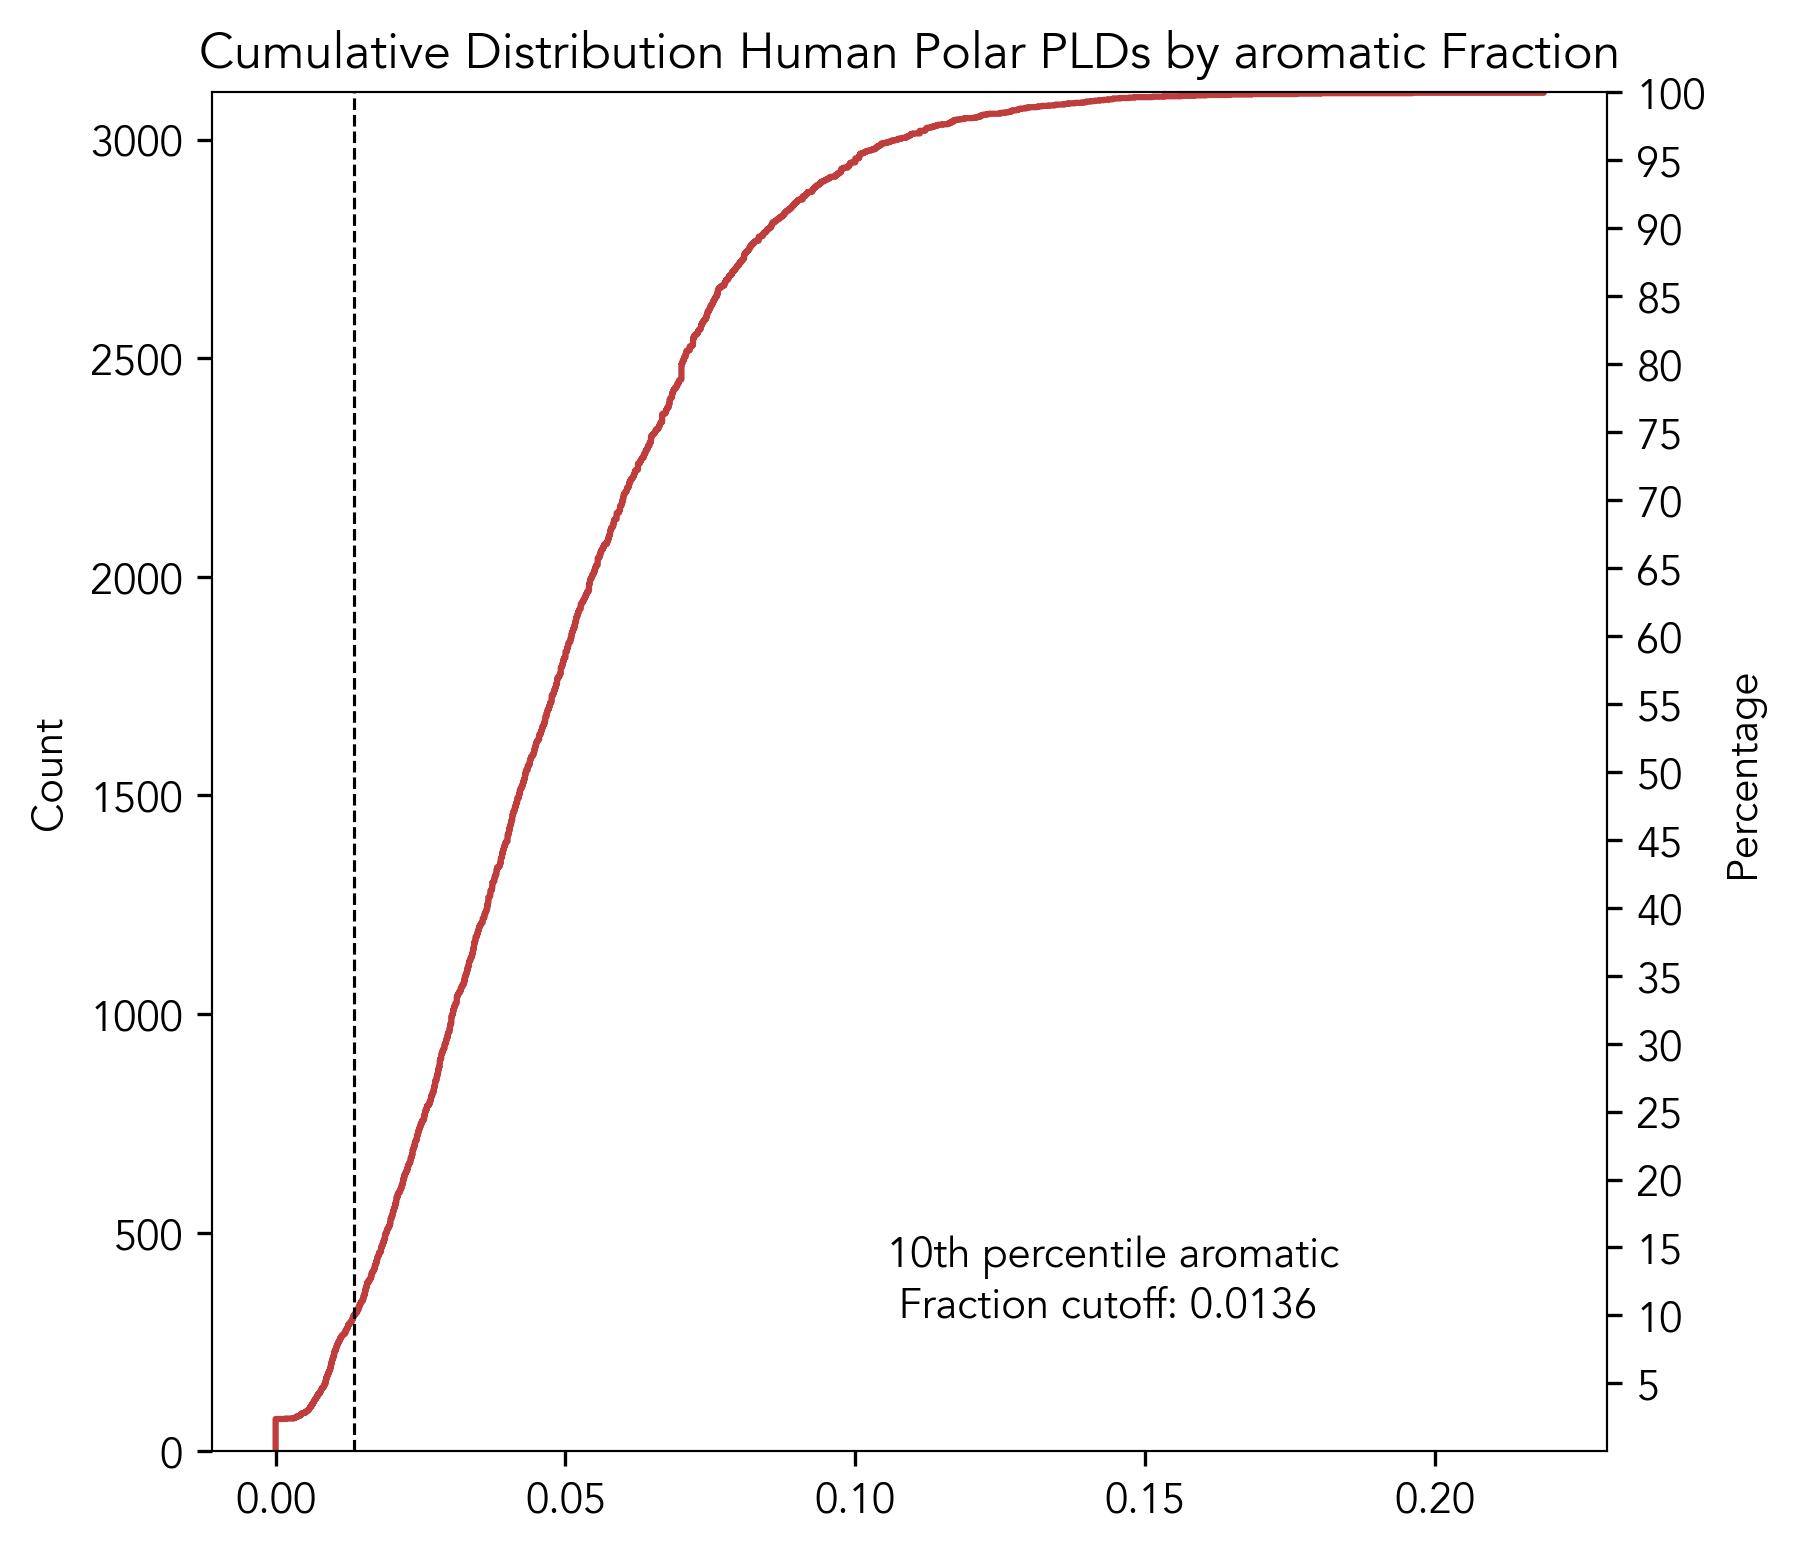

In [8]:
# Example plotting and calling the proteome attribute percentile functions
percentile = 10
chemical_type = 'aromatic'
local_list = fraction_aromatic_list

# call attribute function passing percentile
l_cutoff = human_prot.attribute('LCD_%s_threshold_fxn' % chemical_type)(percentile)

f, ax = plt.subplots(1,1, figsize=(6, 6), dpi=150, facecolor='w', edgecolor='k')
cp = sns.ecdfplot(x=local_list,stat='count', ax=ax, c='#C03D3E')

cp.set_title('Cumulative Distribution Human Polar PLDs by %s Fraction' % chemical_type)

total_samples = len(local_list)
cax = cp.axes
# bounds of the left y-axis:
ymin, ymax = cax.get_ylim()    
# Create second y-axis for the percentages on the right    
ax1 = cax.twinx()
ax1.set_ylabel('Percentage')
ax1.set_yticks([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
# scale right axis labels to total samples and mutliply with 100 for percentages
ax1.set_ylim(100*ymin/total_samples, 100*ymax/total_samples)

# return 10th percentile value plot line and text on figure 
print('%i th percentile %s Fraction cutoff:' % (percentile,chemical_type), l_cutoff)

f.text(.5,.2,'%ith percentile %s \n Fraction cutoff: %.4f' % (percentile , chemical_type, l_cutoff))
cp.axvline(l_cutoff, ls='--', c='k',lw=.75)

# Plotting and visualization of the LCDs extracted based off of thresholds 

In [9]:
# For convenience and formating the specific data of intrest is exported into a dataframe 
# Plotting is done in seaborn 

# get data for extracted LCDs 
eIDR_protiens = []
eIDR_idrs = []
eIDR_FCR =[]
eIDR_aromatic=[]
eIDR_aliphatc=[]
eIDR_polar=[]
eIDR_proline=[]
for d in lcd_idr_overlap:
    eIDR_FCR.append(float(d.attribute('FCR'))+0.000000001)
    eIDR_aromatic.append(float(d.attribute('fraction_aromatic'))+0.000000001)
    eIDR_aliphatc.append(float(d.attribute('fraction_aliphatic'))+0.000000001)
    eIDR_polar.append(float(d.attribute('fraction_polar'))+0.000000001)
    eIDR_proline.append(float(d.attribute('fraction_proline'))+0.000000001)
    eIDR_protiens.append(d.protein.unique_ID) 
    eIDR_idrs.append(d) 
    
lcd_idr_overlap_data = pd.DataFrame({'IDR':eIDR_idrs,'protien':eIDR_protiens,'FCR':eIDR_FCR, 'fraction_aromatic':eIDR_aromatic,
                                    'fraction_aliphatic':eIDR_aliphatc, 'fraction_polar':eIDR_polar, 'fraction_proline':eIDR_proline})


lcd_idr_overlap_data['FCR_aliphatic'] = lcd_idr_overlap_data['FCR']+ lcd_idr_overlap_data['fraction_aliphatic']
lcd_idr_overlap_data['FCR_aromatic'] = lcd_idr_overlap_data['fraction_aromatic']+ lcd_idr_overlap_data['FCR']
lcd_idr_overlap_data['aliphatic_aromatic'] = lcd_idr_overlap_data['fraction_aromatic'] + lcd_idr_overlap_data['fraction_aliphatic']


lcd_idr_overlap_data['relitve_aromatic'] = lcd_idr_overlap_data['fraction_aromatic'] / (lcd_idr_overlap_data['FCR']+ lcd_idr_overlap_data['fraction_aliphatic'])
lcd_idr_overlap_data['relitve_aliphatic'] = lcd_idr_overlap_data['fraction_aliphatic'] / (lcd_idr_overlap_data['fraction_aromatic']+ lcd_idr_overlap_data['FCR'])
lcd_idr_overlap_data['relitve_FCR'] = lcd_idr_overlap_data['FCR'] / (lcd_idr_overlap_data['fraction_aromatic']+ lcd_idr_overlap_data['fraction_aliphatic'])
lcd_idr_overlap_data['len'] =  lcd_idr_overlap_data['IDR'].apply(lambda d: len(d.sequence))
lcd_idr_overlap_data['domain_type'] =  lcd_idr_overlap_data['IDR'].apply(lambda d: d.domain_type)
lcd_idr_overlap_data['info'] =  lcd_idr_overlap_data['IDR'].apply(lambda d: d.protein.name.split("|")[2].split('OS=')[0])
lcd_idr_overlap_data['position'] =  lcd_idr_overlap_data['IDR'].apply(lambda d: "%i-%i" % (d.start,d.end))
lcd_idr_overlap_data['seq'] =  lcd_idr_overlap_data['IDR'].apply(lambda d: d.sequence)

In [10]:
lcd_idr_overlap_data

IDR protien       FCR  \
0     |Domain: QSGNTP_LCD (123-226, len=104) in prot...  P0CG20  0.134615   
1     |Domain: QSGNTP_LCD (4-185, len=182) in protei...  Q9ULL5  0.087912   
2     |Domain: QSGNTP_LCD (3-124, len=122) in protei...  Q6NWY9  0.090164   
3     |Domain: QSGNTP_LCD (4-120, len=117) in protei...  Q8NHV9  0.179487   
4     |Domain: QSGNTP_LCD (442-553, len=112) in prot...  Q9HCK4  0.169643   
...                                                 ...     ...       ...   
3103  |Domain: QSGNTP_LCD (279-500, len=222) in prot...  Q3KP66  0.184685   
3104  |Domain: QSGNTP_LCD (1803-2115, len=313) in pr...  P48634  0.108626   
3105  |Domain: QSGNTP_LCD (13-227, len=215) in prote...  P08575  0.106977   
3106  |Domain: QSGNTP_LCD (144-619, len=476) in prot...  Q7Z5J4  0.149160   
3107  |Domain: QSGNTP_LCD (203-375, len=173) in prot...  P51991  0.092486   

      fraction_aromatic  fraction_aliphatic  fraction_polar  fraction_proline  \
0              0.057692            0.230769        0.326923          0.201923   
1              0.087912            0.258242        0.384615          0.131868   
2              0.057377            0.336066        0.204918          0.303279   
3              0.034188            0.247863        0.384615          0.119658   
4              0.062500            0.232143        0.428571          0.098214   
...                 ...                 ...             ...               ...   
3103           0.054054            0.180180        0.346847          0.184685   
3104           0.073482            0.261981        0.345048          0.191693   
3105           0.046512            0.232558        0.483721          0.106977   
3106           0.060924            0.222689        0.411765          0.102941   
3107           0.144509            0.023121        0.716763          0.023121   

      FCR_aliphatic  FCR_aromatic  aliphatic_aromatic  relitve_aromatic  \
0          0.365385      0.192308            0.288462          0.157895   
1          0.346154      0.175824            0.346154          0.253968   
2          0.426230      0.147541            0.393443          0.134615   
3          0.427350      0.213675            0.282051          0.080000   
4          0.401786      0.232143            0.294643          0.155556   
...             ...           ...                 ...               ...   
3103       0.364865      0.238739            0.234234          0.148148   
3104       0.370607      0.182109            0.335463          0.198276   
3105       0.339535      0.153488            0.279070          0.136986   
3106       0.371849      0.210084            0.283613          0.163842   
3107       0.115607      0.236994            0.167630          1.250000   

      relitve_aliphatic  relitve_FCR  len domain_type  \
0              1.200000     0.466667  104  QSGNTP_LCD   
1              1.468750     0.253968  182  QSGNTP_LCD   
2              2.277778     0.229167  122  QSGNTP_LCD   
3              1.160000     0.636364  117  QSGNTP_LCD   
4              1.000000     0.575758  112  QSGNTP_LCD   
...                 ...          ...  ...         ...   
3103           0.754717     0.788462  222  QSGNTP_LCD   
3104           1.438596     0.323810  313  QSGNTP_LCD   
3105           1.515152     0.383333  215  QSGNTP_LCD   
3106           1.060000     0.525926  476  QSGNTP_LCD   
3107           0.097561     0.551724  173  QSGNTP_LCD   

                                                   info   position  \
0                  PRR35_HUMAN Proline-rich protein 35     123-226   
1                  PRR12_HUMAN Proline-rich protein 12       4-185   
2     PR40B_HUMAN Pre-mRNA-processing factor 40 homo...      3-124   
3            RHXF1_HUMAN Rhox homeobox family member 1       4-120   
4                     ROBO2_HUMAN Roundabout homolog 2     442-553   
...                                                 ...        ...   
3103     INAVA_HUMAN Innate immunity activator protein     279-500   
3104    

### Extract some LCDs

In [11]:
percentile=10

aromatic_cutoff = human_prot.attribute('LCD_aromatic_threshold_fxn')(10)
FCR_cutoff = human_prot.attribute('LCD_FCR_threshold_fxn')(10) #14
aliphatic_cutoff = human_prot.attribute('LCD_aliphatic_threshold_fxn')(10) #3 

aromatic_polar_lcds = lcd_idr_overlap_data[(lcd_idr_overlap_data['FCR'] < FCR_cutoff) & (lcd_idr_overlap_data['fraction_aliphatic'] < aliphatic_cutoff)]
aliphatic_polar_lcds = lcd_idr_overlap_data[(lcd_idr_overlap_data['FCR'] < FCR_cutoff) & (lcd_idr_overlap_data['fraction_aromatic'] < aromatic_cutoff)]
FCR_polar_lcds = lcd_idr_overlap_data[(lcd_idr_overlap_data['fraction_aromatic'] < aromatic_cutoff) & (lcd_idr_overlap_data['fraction_aliphatic'] < aliphatic_cutoff)]

### Plot and segragate by other residues 

Text(0.5, 0.98, 'Enrichment for polar LCD of Intrest: 10th percentile: Aromatic:0.0136  Aliphatic:0.1607  FCR:0.0737')

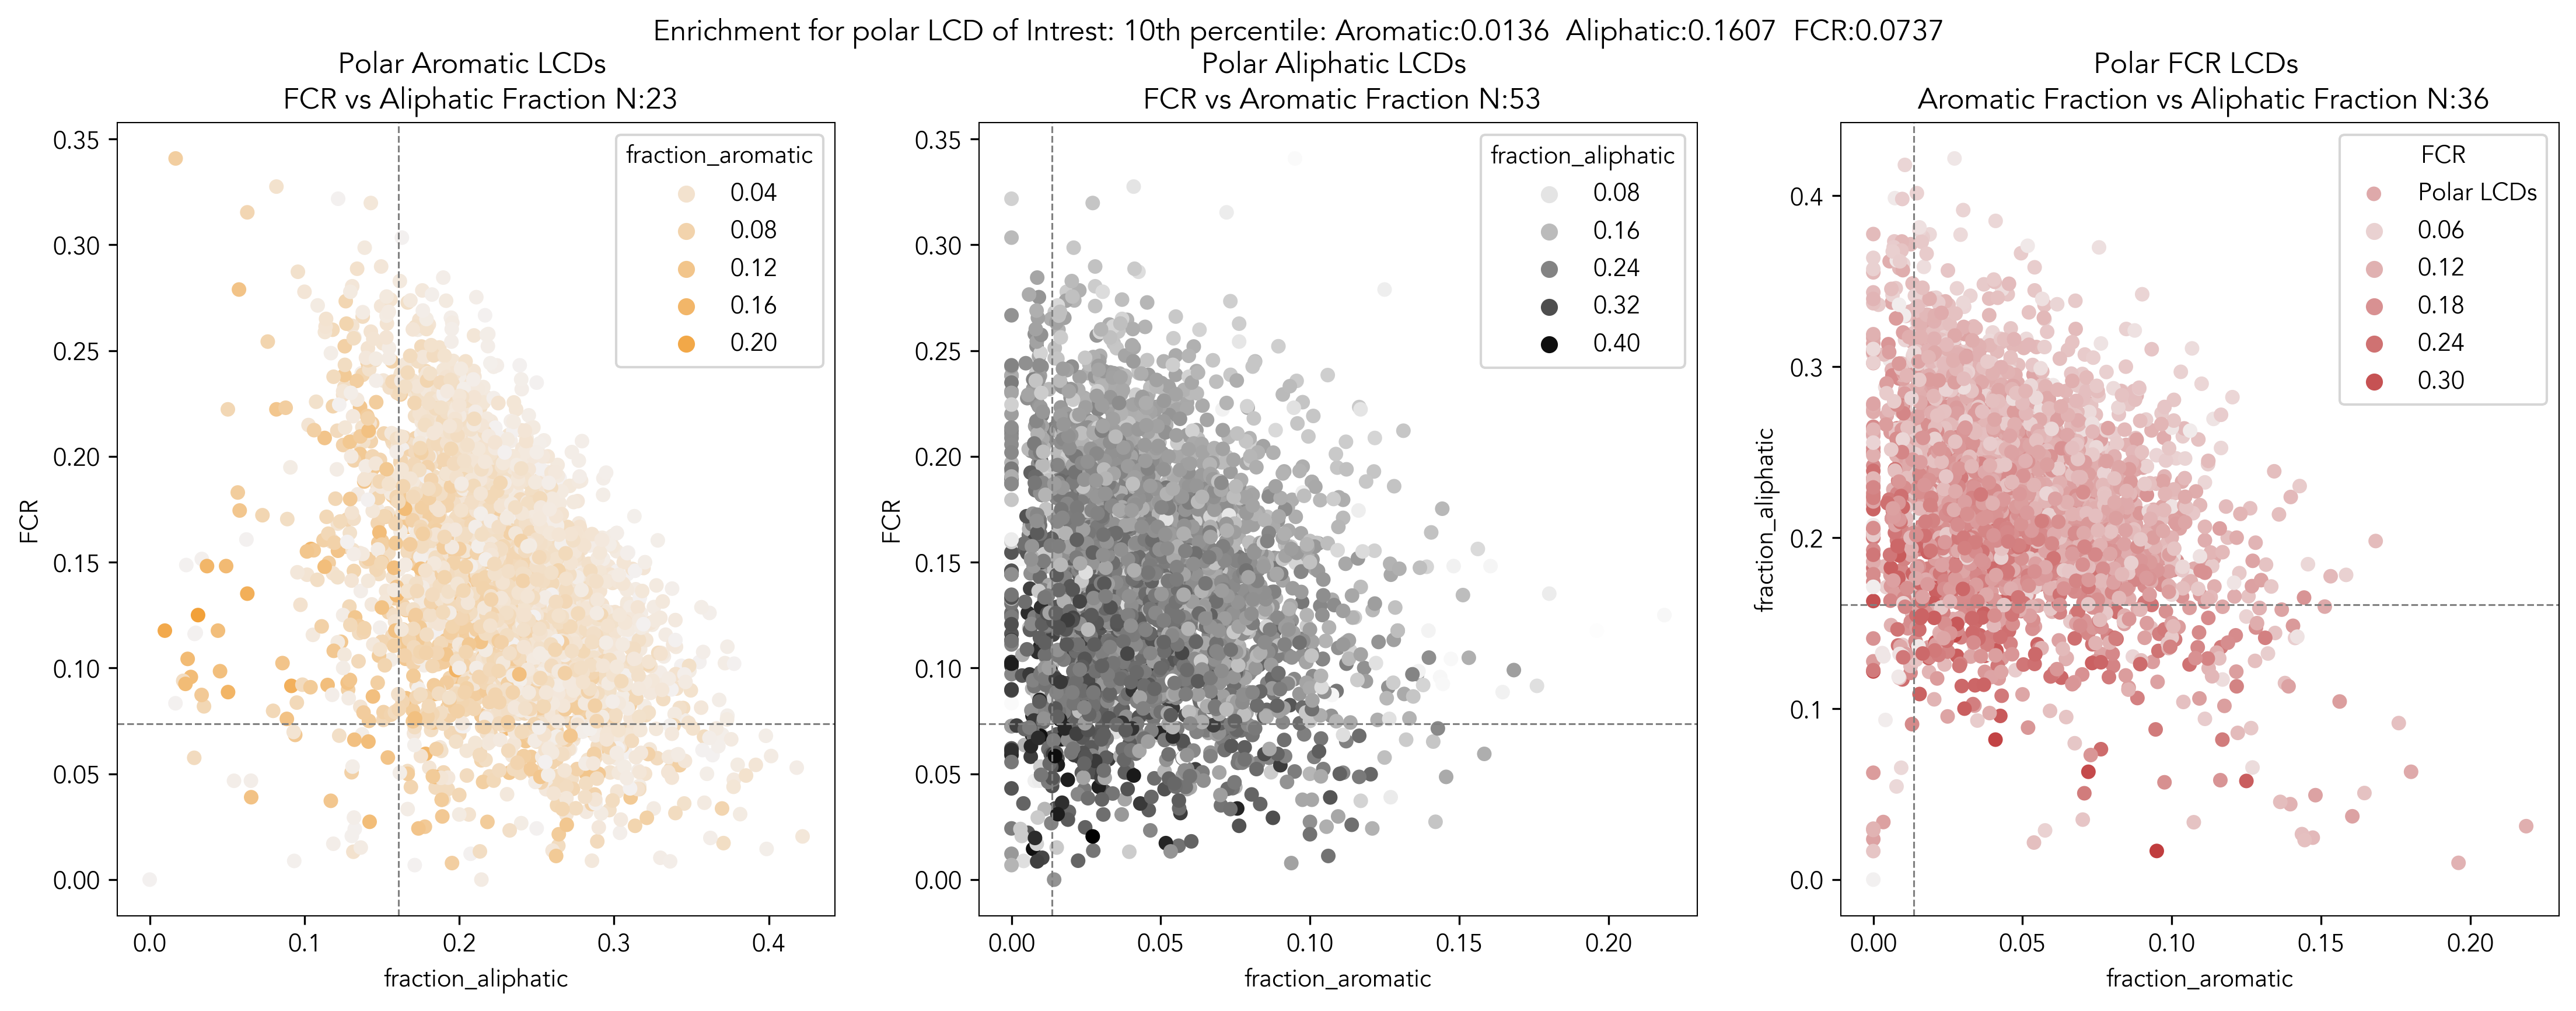

In [12]:
### Getting enrichment for spacers of intrest

f, ax = plt.subplots(1,ncols=3, figsize=(18, 6), dpi=150, facecolor='w', edgecolor='k')

sns.scatterplot(y='FCR', x='fraction_aliphatic', hue='fraction_aromatic', ax=ax[0], data= lcd_idr_overlap_data,
                edgecolor='None', marker='o', palette=aro_palette ,color='lightblue' ,legend=True)
n_idrs0 = len(aromatic_polar_lcds)
ax[0].set_title("Polar Aromatic LCDs \n FCR vs Aliphatic Fraction N:%i" % n_idrs0)
ax[0].axhline(FCR_cutoff, ls='--', c='grey',lw=.75, label='%ith prercentile' % percentile)
ax[0].axvline(aliphatic_cutoff, ls='--', c='grey',lw=.75, label='%ith prercentile' % percentile)

sns.scatterplot(y='FCR', x='fraction_aromatic', hue='fraction_aliphatic', ax=ax[1], data= lcd_idr_overlap_data, 
                edgecolor='None', marker='o', palette=ali_palette ,color='lightblue' ,legend=True)
n_idrs1 = len(aliphatic_polar_lcds)
ax[1].set_title("Polar Aliphatic LCDs \n FCR vs Aromatic Fraction N:%i" % (n_idrs1))
ax[1].axhline(FCR_cutoff, ls='--', c='grey',lw=.75, label='%ith prercentile' % percentile)
ax[1].axvline(aromatic_cutoff, ls='--', c='grey',lw=.75, label='%ith prercentile' % percentile)

sns.scatterplot(y='fraction_aliphatic', x='fraction_aromatic',hue='FCR' , ax=ax[2], data= lcd_idr_overlap_data, 
                edgecolor='None', marker='o', palette=charge_palette, label='Polar LCDs' ,legend=True)
n_idrs2 = len(FCR_polar_lcds)
ax[2].set_title("Polar FCR LCDs \n Aromatic Fraction vs Aliphatic Fraction N:%i" % (n_idrs2))
ax[2].axhline(aliphatic_cutoff, ls='--', c='grey',lw=.75, label='%ith prercentile' % percentile)
ax[2].axvline(aromatic_cutoff, ls='--', c='grey',lw=.75)

f.suptitle("Enrichment for polar LCD of Intrest: %ith percentile: Aromatic:%.4f  Aliphatic:%.4f  FCR:%.4f" % (percentile ,aromatic_cutoff, aliphatic_cutoff, FCR_cutoff))

Text(0.5, 1.0, 'Polar FCR AA Fractions \n 10th percentile N:36')

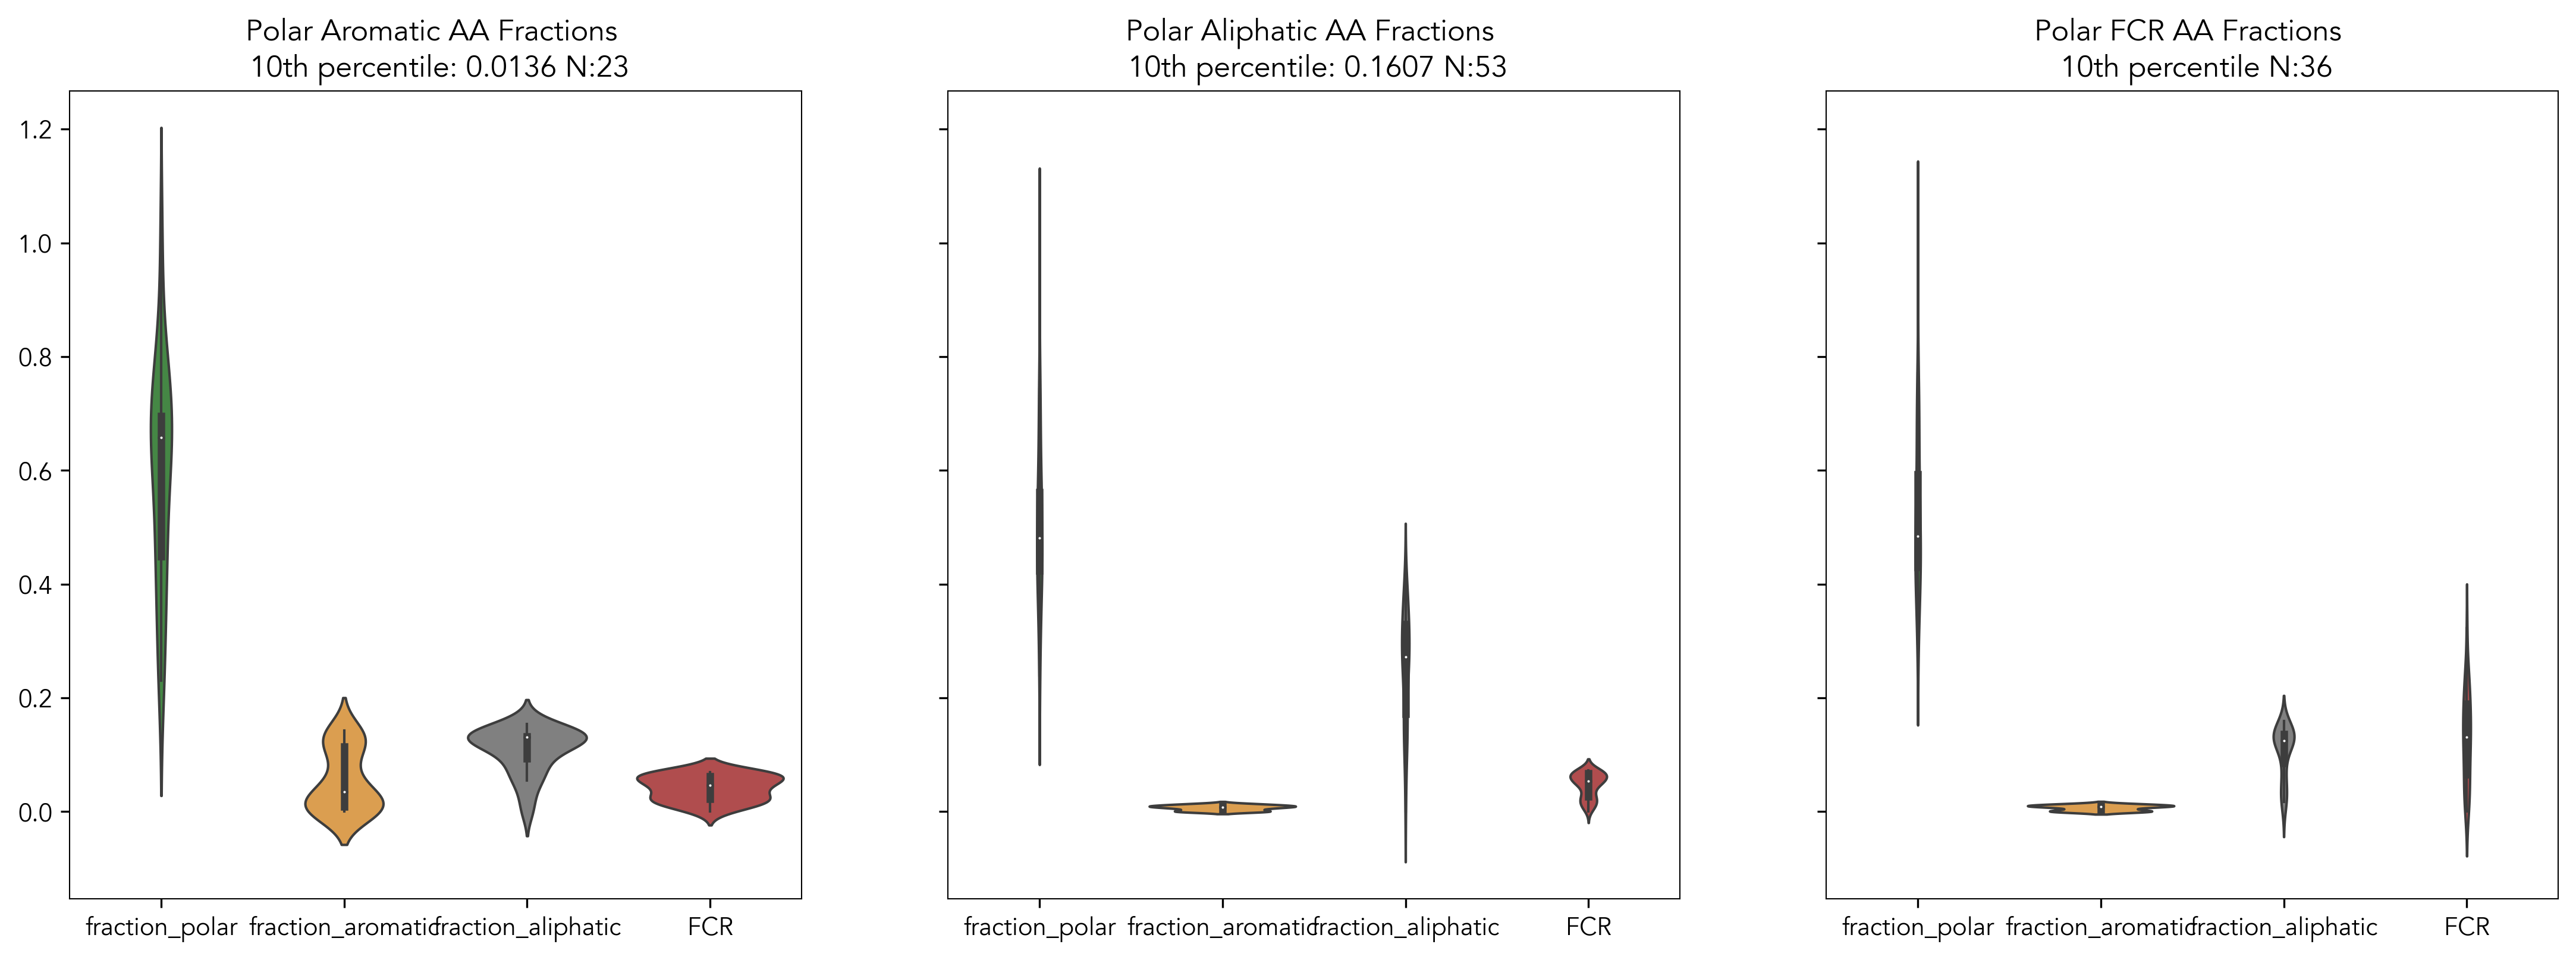

In [13]:
f, ax = plt.subplots(1,ncols=3, figsize=(18, 6), dpi=150, facecolor='w', edgecolor='k', sharey=True)

local_data = aromatic_polar_lcds[['fraction_polar','fraction_aromatic','fraction_aliphatic','FCR']]
sns.violinplot( ax=ax[0], data= local_data, palette=chem_type_palette, linewidth=1)
n_idrs0 = len(local_data)
ax[0].set_title("Polar Aromatic AA Fractions \n %ith percentile: %.4f N:%i" % (percentile, aromatic_cutoff,n_idrs0))

local_data = aliphatic_polar_lcds[['fraction_polar','fraction_aromatic','fraction_aliphatic','FCR']]
sns.violinplot( ax=ax[1], data= local_data, palette=chem_type_palette, linewidth=1)
n_idrs1 = len(local_data)
ax[1].set_title("Polar Aliphatic AA Fractions \n %ith percentile: %.4f N:%i" % (percentile,aliphatic_cutoff,n_idrs1))

local_data = FCR_polar_lcds[['fraction_polar','fraction_aromatic','fraction_aliphatic','FCR']]
sns.violinplot( ax=ax[2], data= local_data, palette=chem_type_palette, linewidth=1)
n_idrs0 = len(local_data)
ax[2].set_title("Polar FCR AA Fractions \n %ith percentile N:%i" % (percentile,n_idrs2))



### Get Co-depletion of spacers and LCDs by chemical sticker type

#### Extract LCDs depleated in non-sticker chemical fractions 

In [14]:
# depletion percentiles 
p0 =3
p1 =3
p2 =3

# define relitive threshold for chemical type of intrest 
r_p = 0.5

# define depletion thresholds for the combination of each chemical type 
FCR_aliphatic_cutoff = np.percentile(np.array(lcd_idr_overlap_data['FCR_aliphatic']), p0)
FCR_aromatic_cutoff = np.percentile(np.array(lcd_idr_overlap_data['FCR_aromatic']), p1) 
aliphatic_aromatic_cutoff = np.percentile(np.array(lcd_idr_overlap_data['aliphatic_aromatic']), p2)

# filter out LCDs below depletion cutoff but above chemical threshold of intrest 
aromatic_polar_lcds_d = lcd_idr_overlap_data[(lcd_idr_overlap_data['FCR_aliphatic'] < FCR_aliphatic_cutoff) & (lcd_idr_overlap_data['relitve_aromatic'] > r_p)]
aliphatic_polar_lcds_d= lcd_idr_overlap_data[(lcd_idr_overlap_data['FCR_aromatic'] < FCR_aromatic_cutoff) & (lcd_idr_overlap_data['relitve_aliphatic'] > r_p)]
FCR_polar_lcds_d = lcd_idr_overlap_data[(lcd_idr_overlap_data['aliphatic_aromatic'] < aliphatic_aromatic_cutoff) & (lcd_idr_overlap_data['relitve_FCR'] > r_p)]

Text(0.5, 0.98, 'Enrichment for polar LCD of Intrest: 3th FCR_aliphatic P:0.0136  3th FCR_aromatic P:0.1607  3th aliphatic_aromatic P:0.0737')

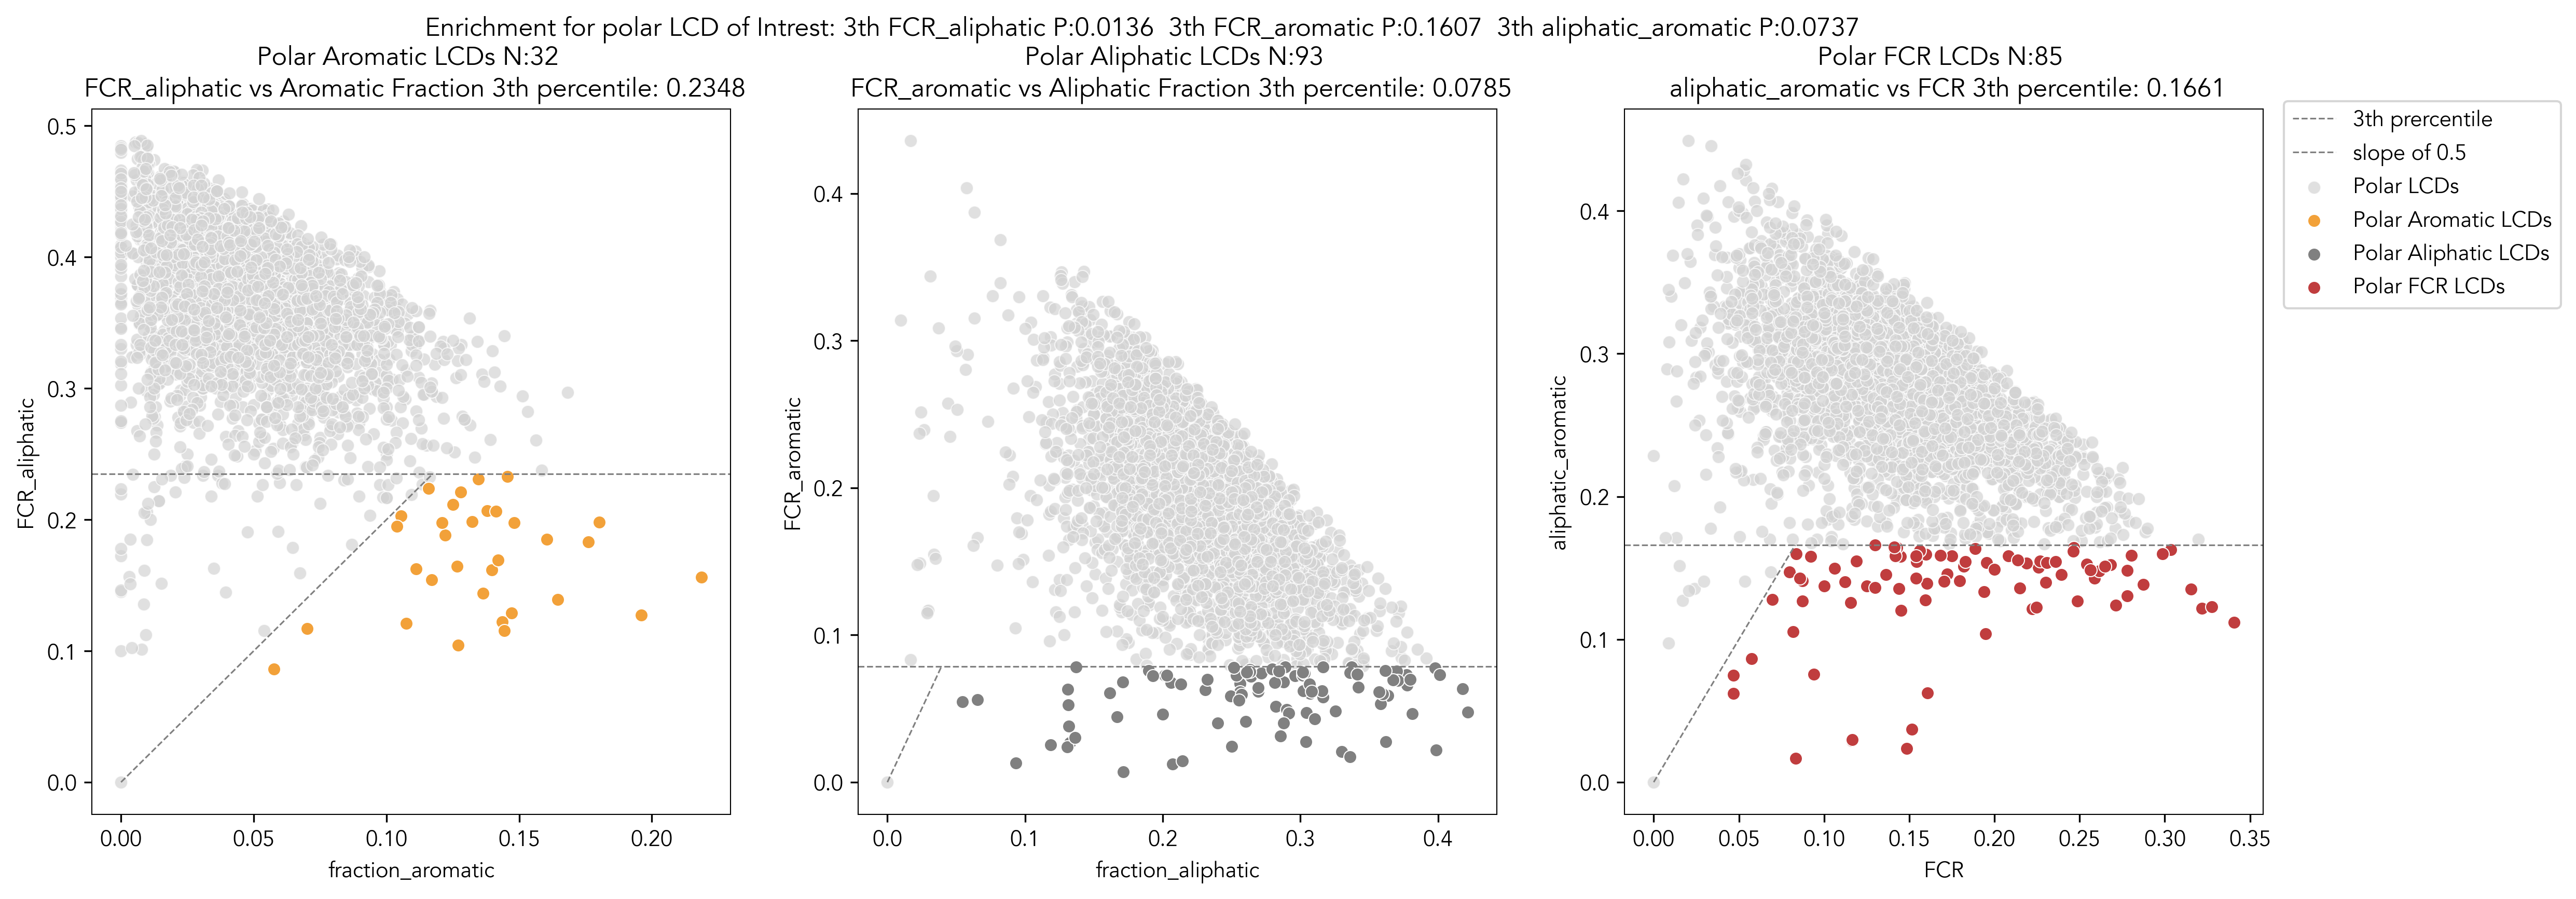

In [22]:
### Getting enrichment for spacers of intrest

f, ax = plt.subplots(1,ncols=3, figsize=(18, 6), dpi=150, facecolor='w', edgecolor='k')


n_idrs0 = len(aromatic_polar_lcds_d)
sns.scatterplot(y='FCR_aliphatic', x='fraction_aromatic', ax=ax[0], data= lcd_idr_overlap_data, marker='o',color='lightgrey', alpha=.7, label='Polar LCDs',legend=False)
sns.scatterplot(y='FCR_aliphatic', x='fraction_aromatic', ax=ax[0], data= aromatic_polar_lcds_d, marker='o',color='#f2a139', label='Polar Aromatic LCDs'   ,legend=False)
ax[0].set_title("Polar Aromatic LCDs N:%i \n FCR_aliphatic vs Aromatic Fraction %ith percentile: %.4f" % (n_idrs0,p0, FCR_aliphatic_cutoff))
ax[0].axhline(FCR_aliphatic_cutoff, ls='--', c='grey',lw=.75, label='%ith prercentile' % p0)
ax[0].plot([0,FCR_aliphatic_cutoff/2],[0,FCR_aliphatic_cutoff], ls='--', c='grey',lw=.75,label='slope of 0.5')

n_idrs1 = len(aliphatic_polar_lcds_d)
sns.scatterplot(y='FCR_aromatic', x='fraction_aliphatic', ax=ax[1], data= lcd_idr_overlap_data,  marker='o',color='lightgrey', alpha=.7,legend=False)
sns.scatterplot(y='FCR_aromatic', x='fraction_aliphatic', ax=ax[1], data= aliphatic_polar_lcds_d, marker='o',color='Grey', label='Polar Aliphatic LCDs'  ,legend=False)
ax[1].set_title("Polar Aliphatic LCDs N:%i \n FCR_aromatic vs Aliphatic Fraction %ith percentile: %.4f" % (n_idrs1, p1, FCR_aromatic_cutoff))
ax[1].axhline(FCR_aromatic_cutoff, ls='--', c='grey',lw=.75)
ax[1].plot([0,FCR_aromatic_cutoff/2],[0,FCR_aromatic_cutoff], ls='--', c='grey',lw=.75)

n_idrs2 = len(FCR_polar_lcds_d)
sns.scatterplot(y='aliphatic_aromatic', x='FCR', ax=ax[2], data= lcd_idr_overlap_data,  marker='o',color='lightgrey', alpha=.7 ,legend=False)
sns.scatterplot(y='aliphatic_aromatic', x='FCR', ax=ax[2], data= FCR_polar_lcds_d, marker='o',color='#C03D3E', label='Polar FCR LCDs' ,legend=False)
ax[2].set_title("Polar FCR LCDs N:%i \n aliphatic_aromatic vs FCR %ith percentile: %.4f" % (n_idrs2,p2, aliphatic_aromatic_cutoff))
ax[2].axhline(aliphatic_aromatic_cutoff, ls='--', c='grey',lw=.75)
ax[2].plot([0,aliphatic_aromatic_cutoff/2],[0,aliphatic_aromatic_cutoff], ls='--', c='grey',lw=.75)



plotting_labels = [ax.get_legend_handles_labels() for ax in f.axes]
marks, labels = [sum(lol, []) for lol in zip(*plotting_labels)]

f.legend(marks, labels, bbox_to_anchor=(1.01, .9), loc='upper right')
f.suptitle("Enrichment for polar LCD of Intrest: %ith FCR_aliphatic P:%.4f  %ith FCR_aromatic P:%.4f  %ith aliphatic_aromatic P:%.4f" % (p0,aromatic_cutoff, p1,aliphatic_cutoff,p2, FCR_cutoff))

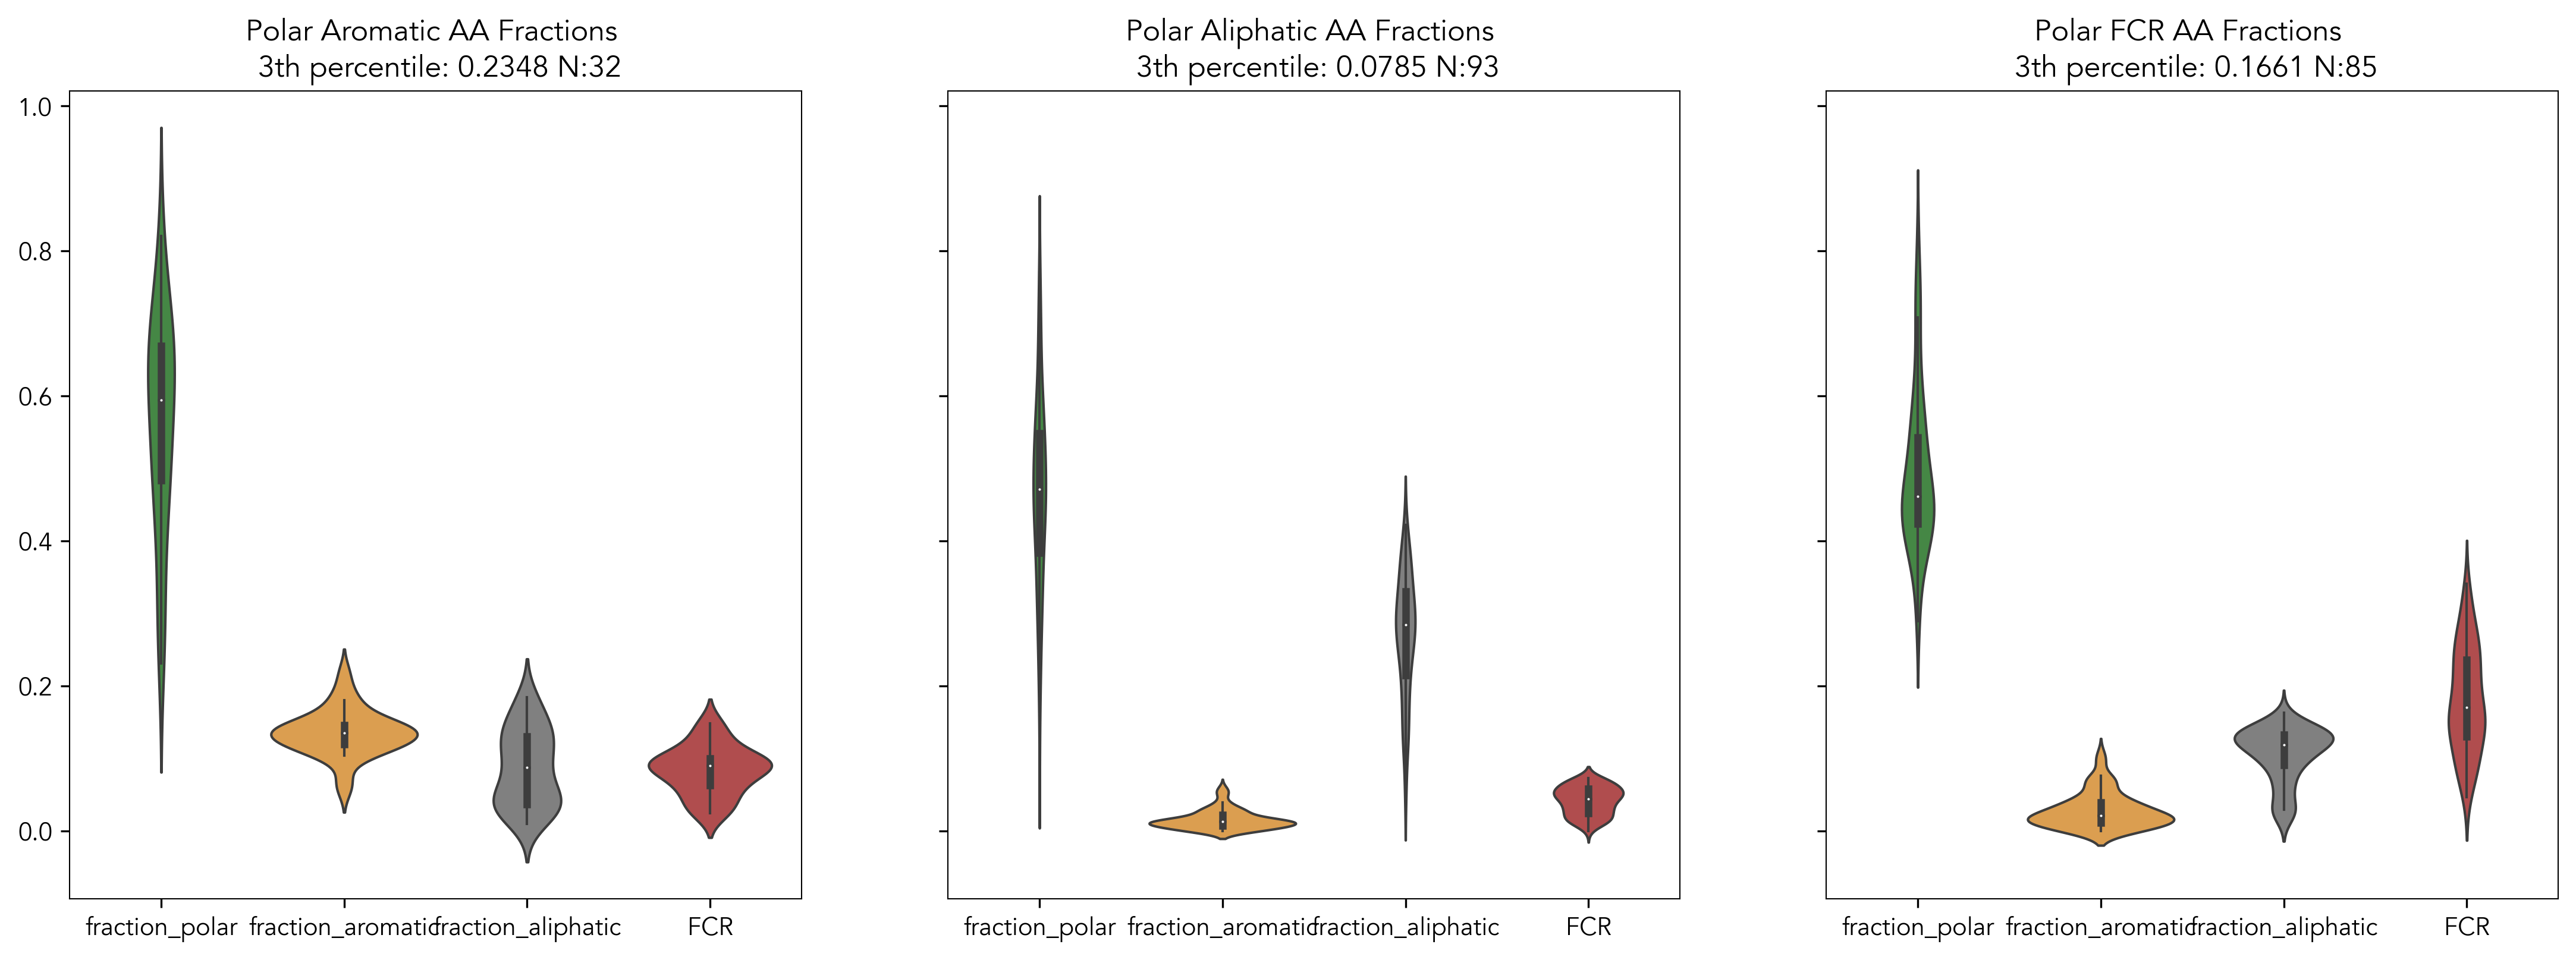

In [23]:
f, ax = plt.subplots(1,ncols=3, figsize=(18, 6), dpi=150, facecolor='w', edgecolor='k', sharey=True)

local_data = aromatic_polar_lcds_d[['fraction_polar','fraction_aromatic','fraction_aliphatic','FCR']]
sns.violinplot( ax=ax[0], data= local_data, palette=chem_type_palette,linewidth=1)
n_idrs0 = len(local_data)
ax[0].set_title("Polar Aromatic AA Fractions \n %ith percentile: %.4f N:%i" % (p0, FCR_aliphatic_cutoff,n_idrs0))

local_data = aliphatic_polar_lcds_d[['fraction_polar','fraction_aromatic','fraction_aliphatic','FCR']]
sns.violinplot( ax=ax[1], data= local_data, palette=chem_type_palette, linewidth=1)
n_idrs1 = len(local_data)
ax[1].set_title("Polar Aliphatic AA Fractions \n %ith percentile: %.4f N:%i" % (p1, FCR_aromatic_cutoff,n_idrs1))

local_data =FCR_polar_lcds_d[['fraction_polar','fraction_aromatic','fraction_aliphatic','FCR']]
sns.violinplot( ax=ax[2], data= local_data, palette=chem_type_palette, linewidth=1)
n_idrs0 = len(local_data)
ax[2].set_title("Polar FCR AA Fractions \n %ith percentile: %.4f N:%i" % (p2,aliphatic_aromatic_cutoff,n_idrs2))

### Evaluating for PLD overlapp 

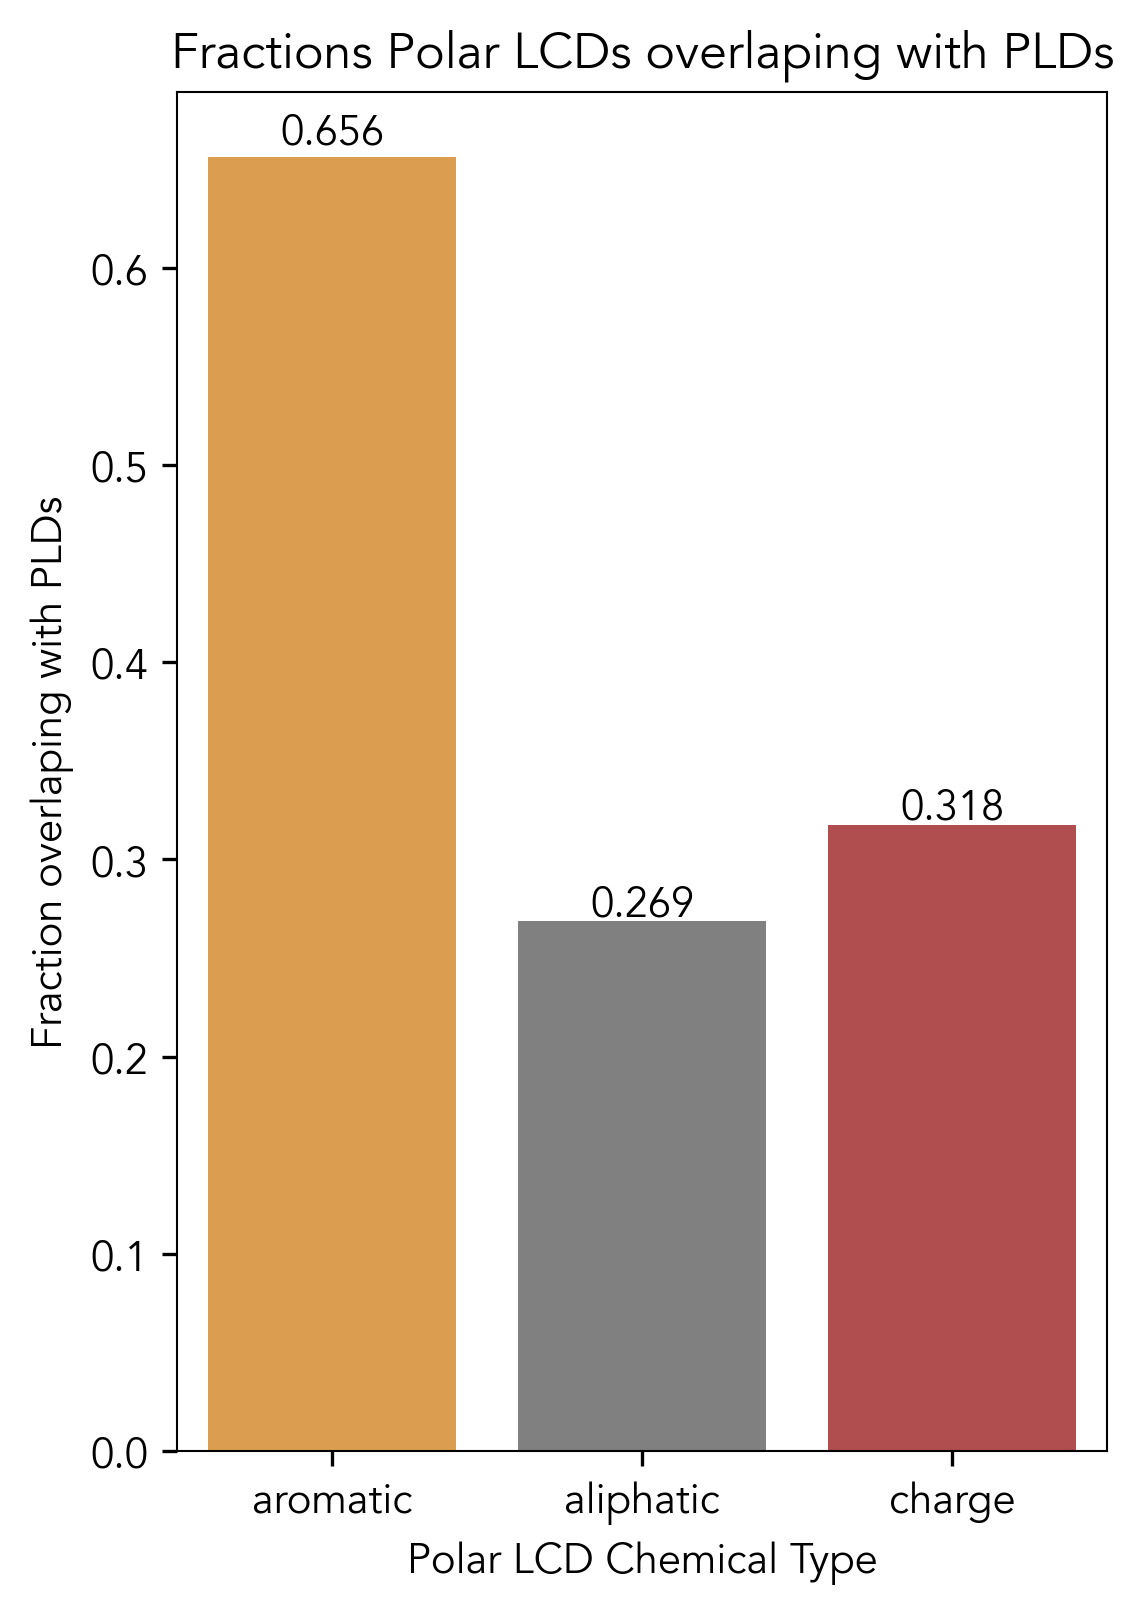

In [24]:
## Calculate and plot fraction of LCDs that overlap with PLDs 
plotting_list =[]
labels=[]
for chem,chem_lcd in [("aromatic",aromatic_polar_lcds_d), ('aliphatic',aliphatic_polar_lcds_d), ('charge',FCR_polar_lcds_d)]:
    tc =0
    pldc=0
    for d in chem_lcd['IDR']:
        if 'PLD_overlap' in d.attributes:
            pld = "plaac_pld"
            pldc+=1 
        else:
            pld = ''
        tc+=1
    plotting_list.append(pldc/tc)
    labels.append(chem)

plot = pd.DataFrame({'Polar LCD Chemical Type':labels, 'Fraction overlaping with PLDs':plotting_list})
f, ax = plt.subplots(1,1, figsize=(4, 6), dpi=150, facecolor='w', edgecolor='k', sharey=True)
p = sns.barplot(y='Fraction overlaping with PLDs', x='Polar LCD Chemical Type', palette=chem_order,data=plot, ax=ax)
ax.set_title("Fractions Polar LCDs overlaping with PLDs")
show_values(p)

### Distributions of number of LCDs by chemical type 
##### Based on competeing chemical type fractions  

Text(0.5, 1.0, '# of Polar Aromatic LCDs \n Aromatic Fraction vs Aliphatic Fraction')

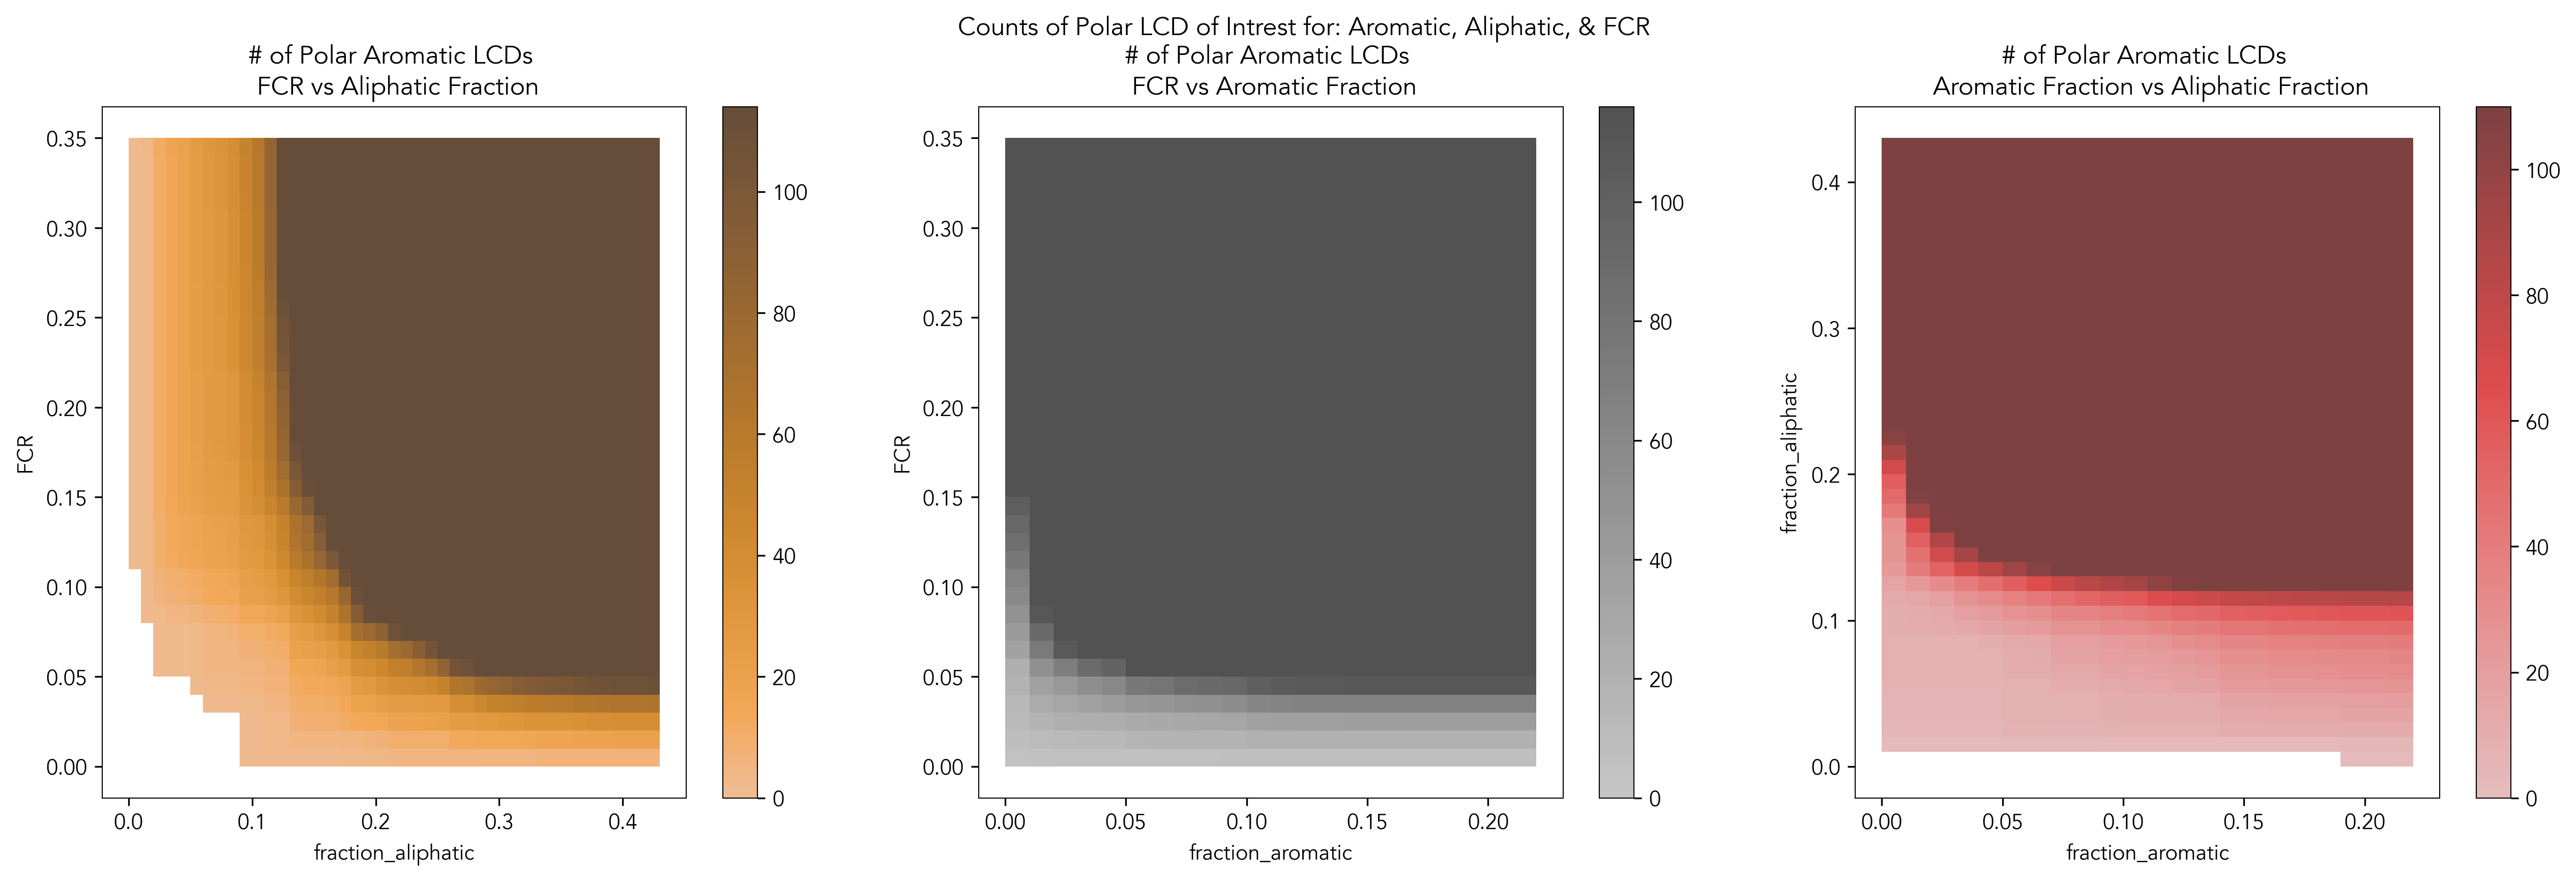

In [18]:
### Plot number of LCDs for different catagories for spacers of intrest

f, ax = plt.subplots(1,ncols=3, figsize=(21, 6), dpi=150, facecolor='w', edgecolor='k')
f.suptitle("Counts of Polar LCD of Intrest for: Aromatic, Aliphatic, & FCR")
local_data = lcd_idr_overlap_data

aro = sns.histplot(y='FCR', x='fraction_aliphatic', ax=ax[0],data=local_data, thresh=1, binwidth=0.01, cumulative=True, pmax=.014,
             stat='count', color='#f2a139',legend=True, cbar=True)
ax[0].set_title("# of Polar Aromatic LCDs \n FCR vs Aliphatic Fraction" )


ali = sns.histplot(y='FCR', x='fraction_aromatic', ax=ax[1],data=local_data,common_bins=True,binwidth=0.01, cumulative=True,thresh=1,pmax=.005,
             stat='count', color='Grey',legend=True, cbar=True)
ax[1].set_title("# of Polar Aromatic LCDs \n FCR vs Aromatic Fraction")


chrg = sns.histplot(y='fraction_aliphatic', x='fraction_aromatic', ax=ax[2],data=local_data,common_bins=True,binwidth=0.01, cumulative=True,thresh=1,pmax=.007,
             stat='count', color='#C03D3E',legend=True, cbar=True)

ax[2].set_title("# of Polar Aromatic LCDs \n Aromatic Fraction vs Aliphatic Fraction")



##### Based on relivtive chemical type fractions  

Text(0.5, 1.0, '# of Polar Aromatic LCDs \n Aromatic Fraction vs Aliphatic Fraction')

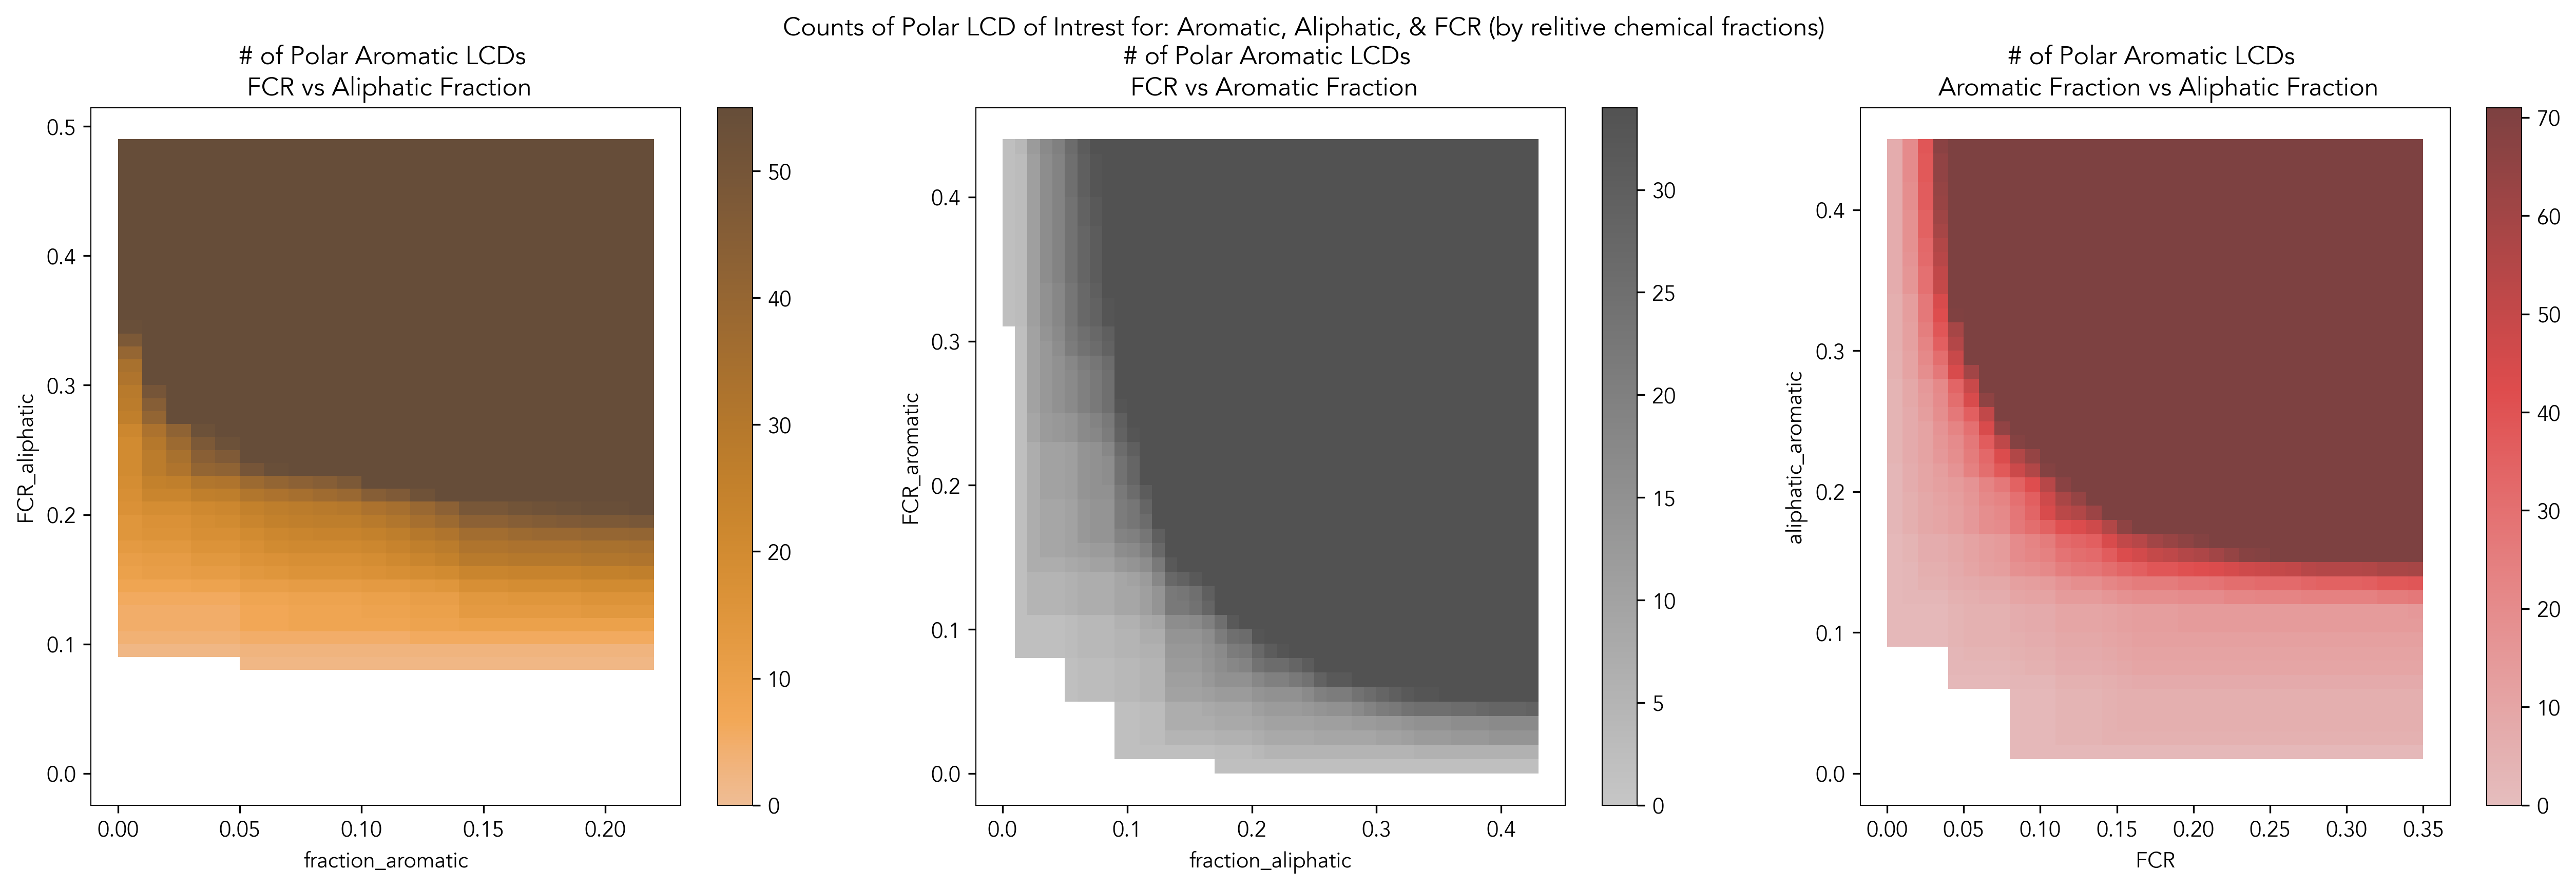

In [19]:
### Plot number of LCDs for different catagories for spacers of intrest

f, ax = plt.subplots(1,ncols=3, figsize=(21, 6), dpi=150, facecolor='w', edgecolor='k')
f.suptitle("Counts of Polar LCD of Intrest for: Aromatic, Aliphatic, & FCR (by relitive chemical fractions)")

local_data = lcd_idr_overlap_data.copy()
aro = sns.histplot(y='FCR_aliphatic', x='fraction_aromatic', ax=ax[0],data=local_data, thresh=1, binwidth=0.01, cumulative=-1, pmax=.01,
             stat='count', color='#f2a139',legend=True, cbar=True)

ax[0].set_title("# of Polar Aromatic LCDs \n FCR vs Aliphatic Fraction" )

local_data = lcd_idr_overlap_data.copy()
ali = sns.histplot(y='FCR_aromatic', x='fraction_aliphatic', ax=ax[1],data=local_data,common_bins=True,binwidth=0.01, cumulative=True,thresh=1,pmax=.005,
             stat='count', color='Grey',legend=True, cbar=True)

ax[1].set_title("# of Polar Aromatic LCDs \n FCR vs Aromatic Fraction")

local_data = lcd_idr_overlap_data.copy()
chrg = sns.histplot(y='aliphatic_aromatic', x='FCR', ax=ax[2],data=local_data,common_bins=True,binwidth=0.01, cumulative=-1,thresh=1,pmax=.01,
             stat='count', color='#C03D3E',legend=True, cbar=True)


ax[2].set_title("# of Polar Aromatic LCDs \n Aromatic Fraction vs Aliphatic Fraction")

